# HKUSTurkey Notebook

## 1. Project Introduction


<img src="images/default_turkey.png" width="30%"></img>

In this project, we are going to train the HKUST Turkey to find out the optimal route of the maze by applying the techniques of Reinforcement Learning.


In the above picture, we can see that the turkey is on the Northe-East side. In the maze, there is a HKUST LOGO which is the terminal point of the maze. Meanwhile, the turkey have to avoid the storm or typhoon trap in the maze and find out the optimal route to the HKUST LOGO. 
- Note that different actions will lead to different rewards. The following list gives the detailed rules:
    - Bumping into the wall: `-10`
    - Reach the HKUST LOGO: `+50`
    - Get trapped into the storm: `-30`
    - Others: `-0.1`
        
        
<img src="images/rules.png" width="40%"></img>

- There are simply 4 actions to take:
    - Up
    - Down
    - Left
    - Right

## 2. Environment Configuration

1. Environment configuration: 
    Firstly, we will have to use the 'environment.yml' file to set up the conda environment named 'hkust-env'. Specifically, the following command line will be executed in terminal.
    - Mac/Linux  
        `conda env create -f environment.yml`

2. Activate the environment
    After the installation, run the following command to activate the environment.
    - Mac/Linux  
        ```conda env create -f environment.yml```
    - Windows  
        ```activate hkust-env```

## 3. Q-Learning


Q-learning is a **model-free** approach, meaning that it not need to gain knowledge of model. Instead, Q-learning **build a table of utility values** as the agent interacts with the environment. 

## 3.1 Q-table
We can find the optimal policy based on a Q-table. **The policy is what we do in any particular state.**In other words, the policy maps the current state to the action.  
  
$$
\Pi(s) = a
$$
    
<img src="images/rr.png" style="width:100%;"><img>
  
  
In Q-Table, Q values represents the value of taking action a in state s, and consists of two components.  

$$
Q[s,a] = immediate\ reward + discounted\ reward
$$

### 3.2 Update Rule
We first initialize all the Q[s,a] to 0, and use the update rule.
`Q'[s,a]` is consists of `old Q[s,a] value` and  `improved estimation`.

#### How to blend them? Use learning rate α!
$$
Q'[s,a] = (1-\alpha) \times Q[s,a] + \alpha \times improved\ estimation
,\alpha \in [0,1]
$$

#### How to calculate improved estimation? Use discount rate γ !
$$
Q'[s,a] = (1-\alpha)\times Q[s,a] + \alpha\times(r + \gamma \times longterm\ rewards), \gamma \in [0,1]
$$

$$
Q'[s,a] = (1-\alpha) \times Q[s,a] + \alpha\times(r + \gamma \times Q[s', \arg\max_{a'}Q[s',a']]), \gamma \in [0,1]
$$


### 3.3 How to choose action?

There are some limitation, we want the agent makes the best choice at each time for maximizing our longterm reward. But here's the problem:

1. At the begining, **we don't have the accurate Q values.** Depending on such Q-table, we **will make a wrong choice.**
2. After learning, the agent will only on a fixed policy and **does not explore the environment.**

---
#### Epsilon-greedy Algorithm

The ϵ-Greedy policy improvement theorem is the stochastic extension of the policy improvement theorem discussed earlier

The motivation for the theorem is that we want to find a way of improving policies while ensuring that we explore the environment. Deterministic policies are no good now as there may be state-action pairs that are never encountered under them.

In our case, we want to add some randomness on choosing action.

In [49]:
import random
import numpy as np
actions = ['u','r','d','l']
# the Q[s',a'] row
q = {'u':1.2, 'r':-2.1, 'd':-24.5, 'l':27}
# set probability of random choise
epsilon = 0.3 
    
def choose_action(epsilon):
    action = None
    # with a random between(0,1)
    if random.random() < epsilon: 
        # choose an action randomly
        action = actions[random.randint(0, len(actions)-1)]
    else:
        # choose the action maximize the Q'[s',a']
        action = max(q.items(), key=operator.itemgetter(1))[0]
    return action

# Verification
for i in range(0, 20):
    print(choose_action(epsilon), end=' ')

l u l d d l d l l l l r l l l l l d r l 

---

## 4. Implementation: Code & Files

There are mainly 3 files in our project. The files can be listed as follows:   
- Maze.py
- Turkey.py
- Runner.py

    1. The `Maze` and `Turkey` class is the main part of our project. So we will describe these two class with more details.   
     
    2. As for the `Runner` class, it's a video generator. It can note down every single step in each epoch so that we can have an overview of the training process.

### 4.1 `Maze`

#### 4.1.1 Maze Algorithm
- **Randomized Prim's algorithm**
- Depth-first search
- Recursive backtracker
- Randomized Kruskal's algorithm
- Modified version
- Wilson's algorithm


   1. In computer science, Prim's (also known as Jarník's) algorithm is a **greedy algorithm** that finds **a minimum spanning tree** for a weighted undirected graph.   
    
<img src="images/prim.png" width="100%"></img>
    
   
   2. Example implementation of a variant of Prim's algorithm in Python/NumPy: Prim's algorithm starts with a grid full of walls and grows a single component of pathable tiles. In this example, we start with an open grid and grow multiple components of walls.  
   
   
   3. This algorithm works by creating **n (density)** islands of **length p (complexity)**. An island is created by choosing a random starting point with odd coordinates, then a random direction is chosen. If the cell two steps in the direction is free, then a wall is added at both one step and two steps in this direction. The process is iterated for **n steps** until **p islands** are created. **n and p** are expressed as float to adapt them to the size of the maze. **With a low complexity, islands are very small and the maze is easy to solve. With low density, the maze has more "big empty rooms"**

The following link shows the details:
[WiKi](https://en.wikipedia.org/wiki/Maze_generation_algorithm)

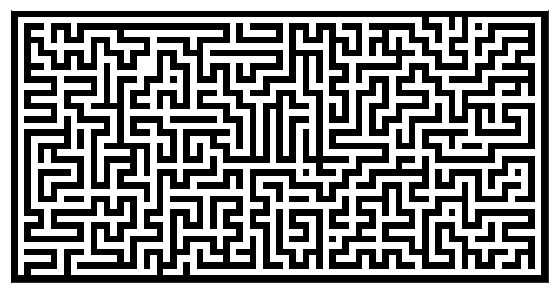

In [2]:
# Randomized Prim's algorithm
import numpy
from numpy.random import random_integers as rand
import matplotlib.pyplot as pyplot
import warnings
warnings.filterwarnings('ignore')

def maze(width=81, height=51, complexity=.75, density=.75):
    # Only odd shapes
    shape = ((height // 2) * 2 + 1, (width // 2) * 2 + 1)
    # Adjust complexity and density relative to maze size
    complexity = int(complexity * (5 * (shape[0] + shape[1]))) # number of components
    density    = int(density * ((shape[0] // 2) * (shape[1] // 2))) # size of components
    # Build actual maze
    Z = numpy.zeros(shape, dtype=bool)
    # Fill borders
    Z[0, :] = Z[-1, :] = 1
    Z[:, 0] = Z[:, -1] = 1
    # Make aisles
    for i in range(density):
        x, y = rand(0, shape[1] // 2) * 2, rand(0, shape[0] // 2) * 2 # pick a random position
        Z[y, x] = 1
        for j in range(complexity):
            neighbours = []
            if x > 1:             neighbours.append((y, x - 2))
            if x < shape[1] - 2:  neighbours.append((y, x + 2))
            if y > 1:             neighbours.append((y - 2, x))
            if y < shape[0] - 2:  neighbours.append((y + 2, x))
            if len(neighbours):
                y_,x_ = neighbours[rand(0, len(neighbours) - 1)]
                if Z[y_, x_] == 0:
                    Z[y_, x_] = 1
                    Z[y_ + (y - y_) // 2, x_ + (x - x_) // 2] = 1
                    x, y = x_, y_
    return Z

pyplot.figure(figsize=(10, 5))
pyplot.imshow(maze(80, 40), cmap=pyplot.cm.binary, interpolation='nearest')
pyplot.xticks([]), pyplot.yticks([])
pyplot.show()

#### 4.1.2 Usage

The `Maze` class can help us create the maze with different size and different situation. It can help you create the maze according to your specification. The following list shows the instruction and code for creating a maze.  
1. `Maze("file_name")`: Create the maze file
2. `Maze(maze_size=(height,width))`: randomly create the maze
3. `trap_number`: the number of traps
4. `g=Maze("xx.txt")`: just use the variable name to print out the maze



---

The following code shows how to create a maze.

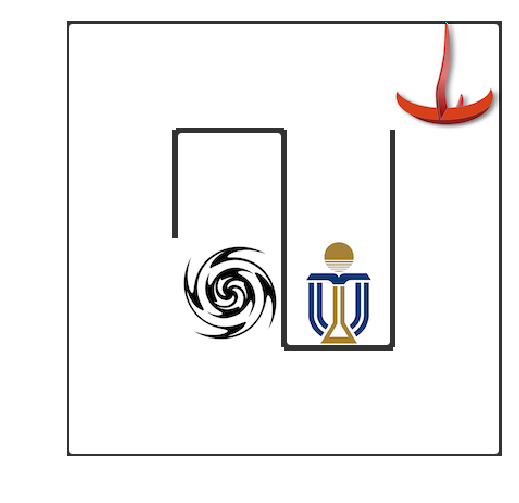

Maze of size (4, 4)

In [7]:
from Maze import Maze
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

maze = Maze(maze_size=(4, 4), trap_number=1)
maze

---

But how to move the turkey and sense the location of the turkey? The following function can solve these problems:
1. `maze.sense_turkey()`: This is a function without any parameters. It will return the location of the turkey in the maze.
2. `maze.move_turkey(direction)`: This function will move the turkey according to the direction.

---

The following code will move the turkey randomly and note down the reward.

Direction: d	Reward: -10.0
Direction: r	Reward: -10.0
Direction: r	Reward: -10.0
Direction: d	Reward: -10.0
Direction: r	Reward: -10.0
Direction: u	Reward: -0.1
Direction: r	Reward: -10.0
Direction: u	Reward: -0.1
Direction: l	Reward: -0.1
Direction: d	Reward: -10.0
(0, 1)


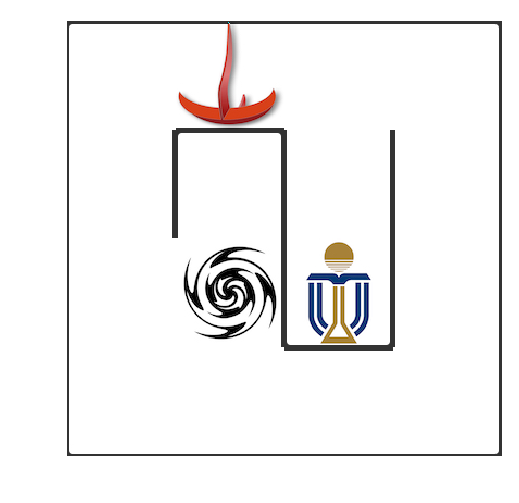

Maze of size (4, 4)


In [11]:
rewards = []

## Iterate 10 times
for i in range(10):
    direction = actions[random.randint(0,3)]
    reward = maze.move_turkey(direction)
    print("Direction: {}\tReward: {}".format(direction, reward))

## Output the location of the turkey
print(maze.sense_turkey())

## Print the maze
print(maze)

### 4.2  `Turkey` 

`Turkey` Class is the main part of our implementation. We have applied the techniques of Reinforcement Learning to train the turkey so that it can reach the HKUST LOGO in an optimal route. Generally speaking, we try to move the turkey by making command without the Reinforcement Learning. However, after adding the Q-Learning Reinforcement Learning, the turkey can now find out the correct route and move by itself! It can learn by itself to update the parameters and Q-table. 


The `Turkey` Class mainly contains the following functions:  
- **set_status(self, learning=False, testing=False);**   
    Determine whether the turkey is learning its q table, or exceuting the testing procedure.  
  
- **update_parameter(self);**  
    This function can help update the value of `epsilon` during the training process. Usually, we will decrease `epsilon` after each epoch so that the turkey will spend less time to explore the optimal route. This is a useful method the make a balance between Exploration and Exploitation.  
  
- **choose_action(self);**     
    Return an action according to given rules.  
  
- **update_Qtable(self, r, action, next_state);**   
    Update the qtable according to the given rule.  
    
- **update(self);**  
    This is the most important function for training the turkey. 
    It describes the procedure what to do when updating the turkey. It is called every time in every single step. Finally, it will return current action and reward.
    

#### 4.2.1 Reinforcement Learning Procedure

The following code shows the `update()` function of the turkey.

In [ ]:
def update(self):
        """
        Describle the procedure what to do when update the turkey.
        Called every time in every epoch in training or testing.
        Return current action and reward.
        """
        self.state = self.sense_state()  # Get the current state
        self.create_Qtable_line(self.state)  # For the state, create q table line

        action = self.choose_action()  # choose action for this state
        reward = self.maze.move_turkey(action)  # move turkey for given action

        next_state = self.sense_state()  # get next state
        self.create_Qtable_line(
            next_state)  # create q table line for next state

        if self.learning and not self.testing:
            self.update_Qtable(reward, action, next_state)  # update q table
            self.update_parameter()  # update parameters

        return action, reward

#### 4.2.2 Choose direction by Q-Learning Algorithm　　

- From line 6, we use the function of `is_random_exploration()` to implement the function of **epsilon**.
- From line 23, we can see that the action which leads to the highest Q value is taken.


In [20]:
def choose_action(self):
        """
        Return an action according to given rules
        """

        def is_random_exploration():

            #  5. Return whether do random choice
            # hint: generate a random number, and compare
            # it with epsilon
            if random.random() < self.epsilon:
                return True
            else:
                return False

        final_action = ''
        if self.learning:
            if is_random_exploration():
                #  6. Return random choose aciton
                final_action = self.valid_actions[random.randint(0, 3)]
            else:
                #  7. Return action with highest q value
                final_action = max(
                    self.Qtable[self.state].items(),
                    key=operator.itemgetter(1))[0]
        elif self.testing:
            #  7. choose action with highest q value
            final_action = max(
                self.Qtable[self.state].items(),
                key=operator.itemgetter(1))[0]
        else:
            #  6. Return random choose aciton
            final_action = self.valid_actions[random.randint(0, 3)]

        return final_action

#### 4.2.3 Update the Q-Table
  
- This function has calculated the Q value for the current state and return it to Q-Table. The algorithm is listed as below:

$$
q(s_{t},a) = (1-\alpha) \times q(s_{t},a) + \alpha \times(R_{t+1} + \gamma \times\max_a q(a,s_{t+1}))
$$

In [21]:
def update_Qtable(self, r, action, next_state):
        """
        Update the qtable according to the given rule.
        """
        if self.learning:
            #  8. When learning, update the q table according
            # to the given rules

            # The reward the turkey get after doing the action
            reward_t1 = r

            # Code Review1: Replace the following code
            '''
            # Get the key & value which enables the max Q value in State(t+1)
            max_Q_St1_info = max(self.Qtable[next_state].items(), key=operator.itemgetter(1))

            # The action which enables the max Q value in State(t+1)
            max_Q_St1_action = max_Q_St1_info[0]

            # The max Q value in State(t+1)
            max_Q_St1 = max_Q_St1_info[1]
            '''
            max_Q_St1 = max(self.Qtable[next_state].values())

            Q_old = self.Qtable[self.state][action]
            Q_new = reward_t1 + self.gamma * max_Q_St1

            self.Qtable[self.state][action] = (
                1 - self.alpha) * Q_old + self.alpha * Q_new

#### 4.2.4 Simple Usage

('u', -10.0)


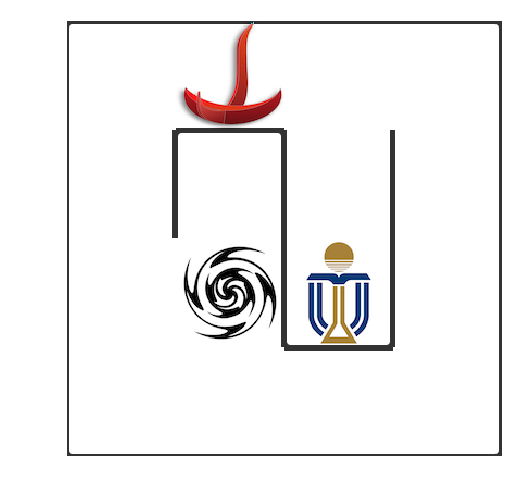

Maze of size (4, 4)


In [18]:
from Turkey import Turkey
turkey = Turkey(maze)
turkey.set_status(learning=True,testing=False)
print(turkey.update())

print(maze)

---

## 5 Results: 

### 5.1 Start Training
After we finished our work above, we can now run the code to train our Turkey. During training ,we can select different value of parameters we talked before to find the difference of Success Times chart ,Accumulated Reward chart , Running Times chart.

---

The main parameters we can adjust includes: 

- Training parameter:
    - training epoch
- Turkey parameters:
    - `epsilon`
    - `alpha`
    - `gamma`
- Maze parameters:
    - the size of the maze
    - the quantity of trap
   

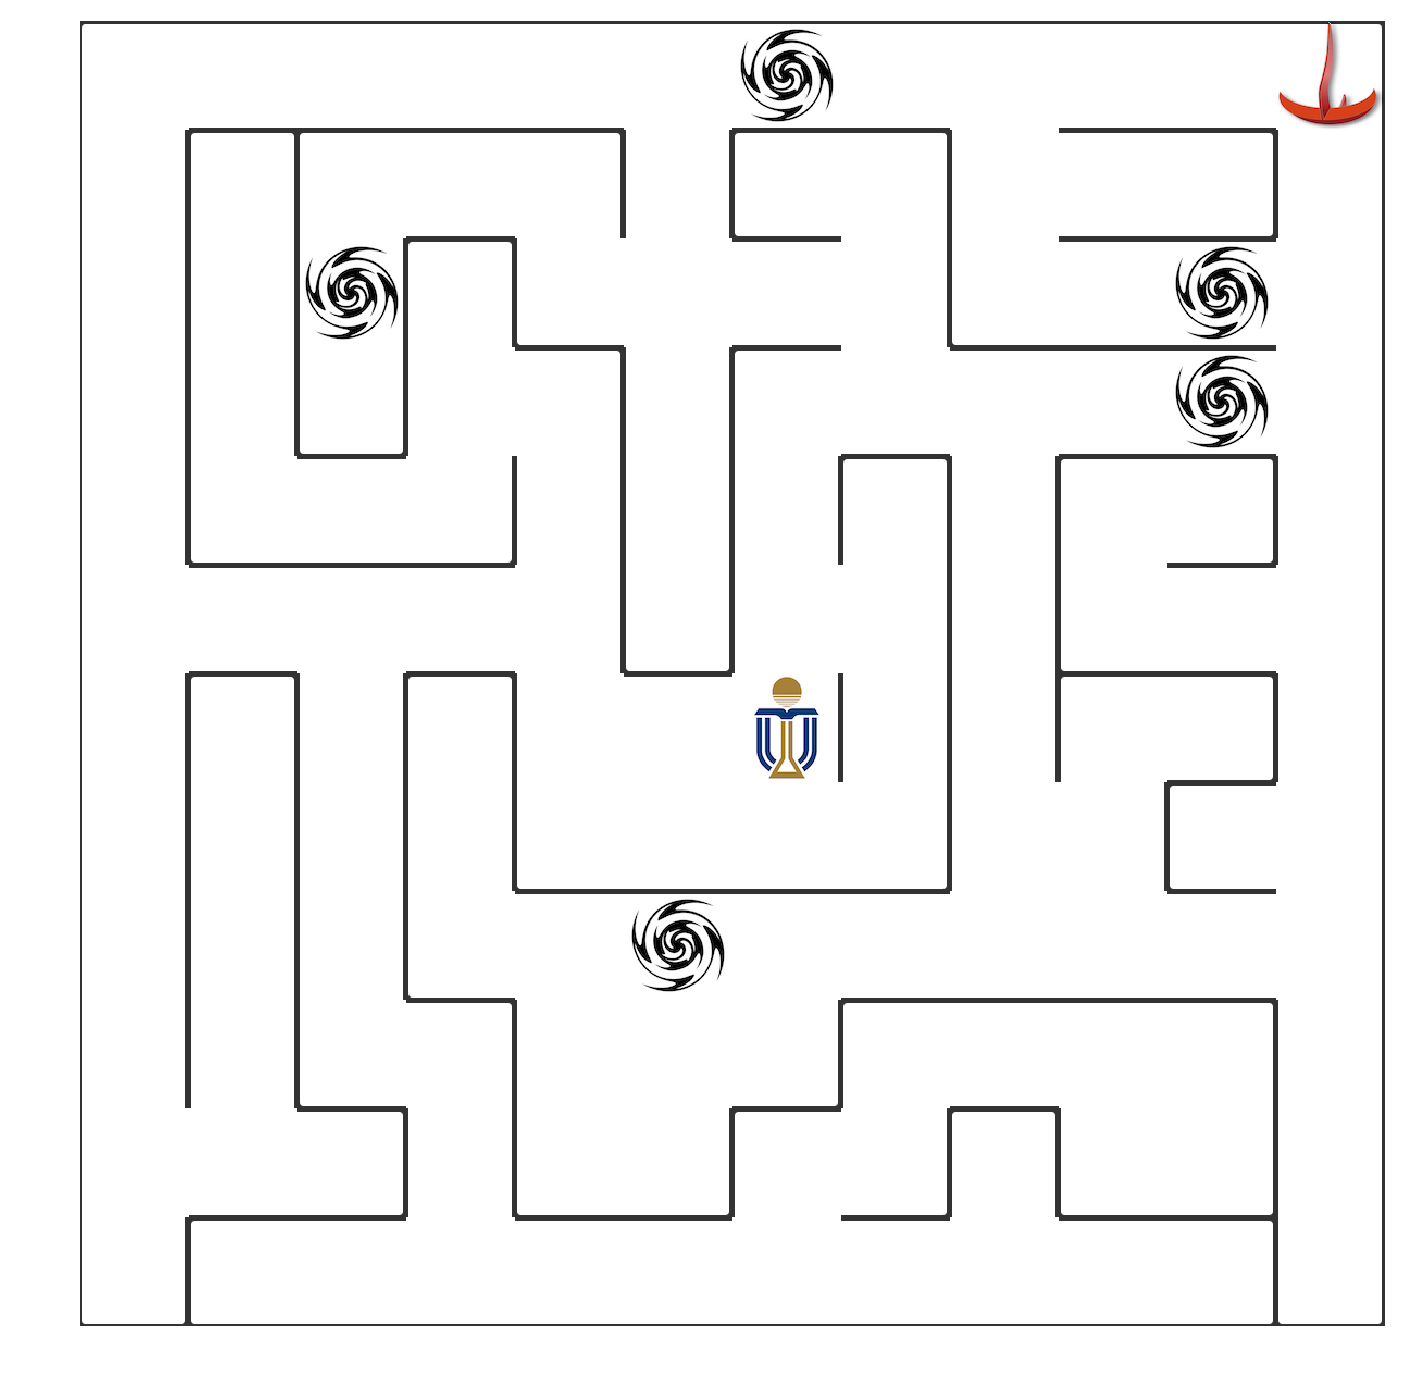

Maze of size (12, 12)


In [25]:
# parameters
epoch = 20
epsilon0 = 0.2
alpha = 1
gamma = 0.5

maze_size = (12, 12)
trap_number = 5

# draw maze
from Runner import Runner

g = Maze(maze_size=maze_size,trap_number=trap_number)
r = Turkey(g,alpha=alpha, epsilon0=epsilon0, gamma=gamma)
r.set_status(learning=True)

print(r)
print(g)

In [51]:
# parameters
epsilon0 = 0.1
alpha = 0.5
gamma = 0.9

epoch = 60
r = Turkey(g,alpha=alpha, epsilon0=epsilon0, gamma=gamma)
r.set_status(learning=True)

runner = Runner(r, g)
runner.run_training(epoch, display_direction=True)
runner.generate_movie(filename = "final_video.mp4")

Generate Movies: 100%|██████████| 3371/3371 [01:58<00:00, 27.81it/s]


### 5.2 Analysis

---

- Success Times chart represents the cumulative number of times our Turkey succeeds in training, which should be an incremental line chart.
- Accumulated Rewards chart represents the accumulated reward value of our Turkey in each training epoch, which should be an incremental line chart.
- Running Times chart represents the sequence of training in each training epoch,which should be an decreasing line chart.


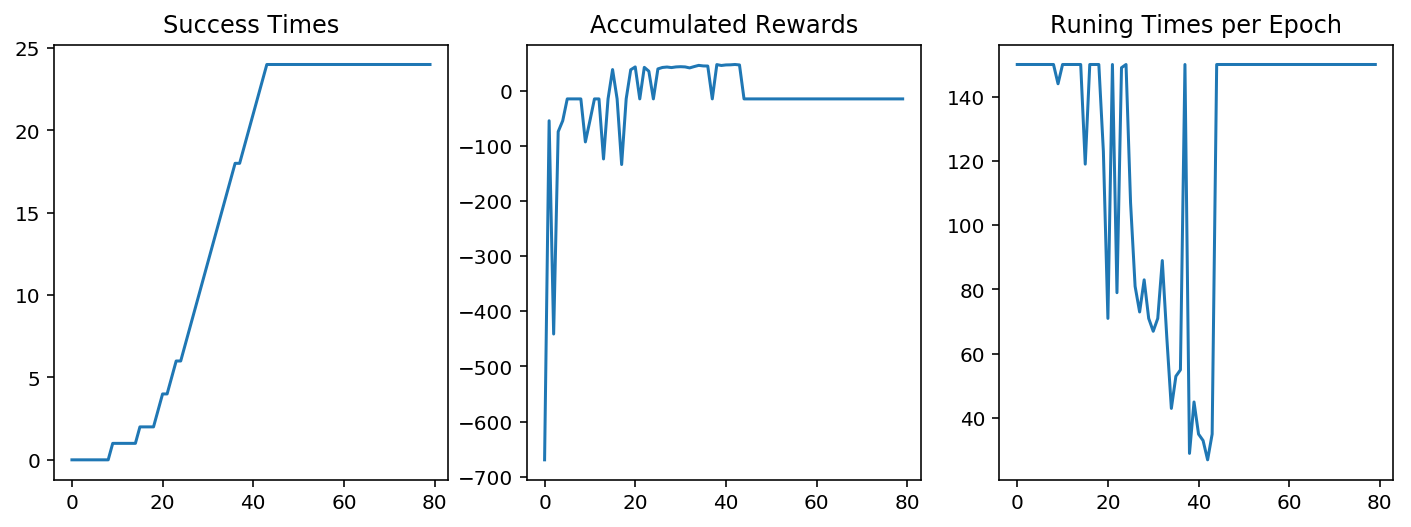

In [29]:
runner.plot_results()

---
#### 5.2.1 alpha
<img src="images/alpha.png" width="60%"></img>

---
#### 5.2.2 gamma
<img src="images/gamma.png" width="60%"></img>

----
#### 5.2.3 epsilon
<img src="images/epsilon.png" width="60%"></img>


- Finally , we select alpha = 0.5; gamma = 0.9; epsilon = 0.1;
    - Alpha=0.5 because both the old Q value and the new Q value should be taken in to account , so that the robot can learn from the old experience while accepting the new experience averagely.
    - Gamma=0.9 because we want to make the Turkey take fully account of experience of future steps ; 
    - epsilon=0.1 because we want to make the Turkey make a choice according to the highest reward , but we also want it to try different way randomly at the begining when it has less experience.This is a trade-off between exploration and exploitation.

## 6. Collaboration

<img src='images/collaboration.png' width='80%'>